<a href="https://www.kaggle.com/code/srishtimishra2512/bees-notebook-resnet50?scriptVersionId=127138078" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pwd

/kaggle/working


**We need to train, test, and validation folders, with each folder containing subfolders of all the classes present in the dataset**

In [4]:
parent_dir = "/kaggle/working"
train_dir = "train"
test_dir = "test"
val_dir = "valid"

#creating train directory
train_path = os.path.join(parent_dir, train_dir)
if not os.path.exists(train_path):
    os.mkdir(train_path)

#creating test directory
test_path = os.path.join(parent_dir, test_dir)
if not os.path.exists(test_path):
    os.mkdir(test_path)
    
#creating val directory
val_path = os.path.join(parent_dir, val_dir)
if not os.path.exists(val_path):
    os.mkdir(val_path)

**Now, we will find out the no. of classes we have in our dataset**

In [5]:
csv_path = '/kaggle/input/honey-bee-annotated-images/bee_data.csv'
df= pd.read_csv(csv_path)
len_df = len(df)
print('length of dataframe',len_df)

length of dataframe 5172


In [6]:
df.head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


**Our target vector here is the health column of the dataframe. We want to find out how many target classes there are in the dataset.**

In [7]:
num_classes = len(list(df['health'].unique()))
print('\033[1m'+'No. of target classes in the data: '+ '\033[0m', num_classes)

No. of target classes in the data:  6


**These names of these 6 target classes are**

In [8]:
print('\033[1m'+'Target classes in the data: '+'\033[0m')
for index, item in enumerate(list(df['health'].unique())):
    print(index+1, item)

Target classes in the data: 
1 hive being robbed
2 healthy
3 few varrao, hive beetles
4 ant problems
5 missing queen
6 Varroa, Small Hive Beetles


**Let's plot some of the images of our dataset to understand the dataset better.**

<class 'pandas.core.frame.DataFrame'>
(59, 49) RGB
(169, 47) RGB
(242, 205) RGB
(47, 56) RGB
(68, 65) RGB


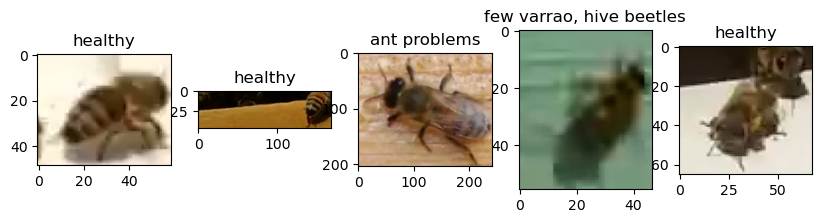

In [71]:
import matplotlib.pyplot as plt
from PIL import Image

input_dir = '/kaggle/input/honey-bee-annotated-images/bee_imgs/bee_imgs'
# this part of the code displays 4 images at a time
fig = plt.figure(figsize=(10, 6))
rows = 1
columns = 5

#display 5 random images from the dataset
df2 = df.sample(n=5)
print(type(df2))

i =0

for index, df2_values in df2.iterrows(): #iterates column wise
    img = Image.open(os.path.join(input_dir, df2_values['file']))
    fig.add_subplot(rows, columns, i+1 if i<5 else i)
    img_name = df2_values['health']
    plt.imshow(img)
    plt.title(img_name)
    print(img.size, img.mode)
    i+=1

**Observation**:
1. **Our images are of different sizes, we need to resize them to the same size.**
2. **We have 6 categories within our datset. Therefore, we need to create 6 sub-directories within each train, test, and validation folders corresponding to each of the 6 classes and copy the images.** 

**First, we will determine the image sizes of the entire dataset to determine the smallest image size present**

In [60]:
width =[]
height = []
for index, df_values in df.iterrows():
    img = Image.open(os.path.join(input_dir, df_values['file']))
    w, h = img.size
    width.append(w)
    height.append(h)

df['width'] = width
df['height'] = height


In [72]:
df.head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste,width,height
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,164,115
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,90,201
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,167,132
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,97,134
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,106,147


In [84]:
min_h = df['height'].min()
min_w = df['width'].min()
min_w_index = df['width'].idxmin()
min_h_index = df['height'].idxmin()
print('\033[1m'+ f'Min width is {min_w} with index at {min_w_index}'+'\033[0m')
print('\033[1m'+ f'Min height is {min_h} with index at {min_h_index}'+'\033[0m')
print(df[['width', 'height']].iloc[min_w_index])
print(df[['width', 'height']].iloc[min_h_index])

Min width is 27 with index at 4362
Min height is 24 with index at 5160
width     27
height    47
Name: 4362, dtype: int64
width     62
height    24
Name: 5160, dtype: int64


In [85]:
max_h = df['height'].max()
max_w = df['width'].max()
print('\033[1m'+ f'Max width is {max_w} & height is {max_h}' + '\033[0m')

Max width is 392 & height is 520


**So we see that the minimum sized images are of the size (27, 47) and (62, 24). We will rezie the images to the smallest width and height i.e 27 and 24 respectively.**

In [ ]:
#creating train directory

class_1 = 'hive being robbed'
class_1_dir = os.path.join(train_path, class_1)
if not os.path.exists(class_1_dir):
    os.mkdir(class_1_dir)
    
class_2 = 'healthy'
class_2_dir = os.path.join(train_path, class_2)
if not os.path.exists(class_2_dir):
    os.mkdir(class_2_dir)
    
class_3 = 'few varrao, hive beetles'
class_3_dir = os.path.join(train_path, class_3)
if not os.path.exists(class_3_dir):
    os.mkdir(class_3_dir)
    
class_4 = 'ant problems'
class_4_dir = os.path.join(train_path, class_4)
if not os.path.exists(class_4_dir):
    os.mkdir(class_4_dir)
    
class_5 = 'missing queen'
class_5_dir = os.path.join(train_path, class_5)
if not os.path.exists(class_5_dir):
    os.mkdir(class_5_dir)
    
class_6 = 'Varroa, Small Hive Beetles'
class_6_dir = os.path.join(train_path, class_6)
if not os.path.exists(class_6_dir):
    os.mkdir(class_6_dir)

In [ ]:
#creating test directory

class_1 = 'hive being robbed'
class_1_dir = os.path.join(test_path, class_1)
if not os.path.exists(class_1_dir):
    os.mkdir(class_1_dir)
    
class_2 = 'healthy'
class_2_dir = os.path.join(test_path, class_2)
if not os.path.exists(class_2_dir):
    os.mkdir(class_2_dir)
    
class_3 = 'few varrao, hive beetles'
class_3_dir = os.path.join(test_path, class_3)
if not os.path.exists(class_3_dir):
    os.mkdir(class_3_dir)
    
class_4 = 'ant problems'
class_4_dir = os.path.join(test_path, class_4)
if not os.path.exists(class_4_dir):
    os.mkdir(class_4_dir)
    
class_5 = 'missing queen'
class_5_dir = os.path.join(test_path, class_5)
if not os.path.exists(class_5_dir):
    os.mkdir(class_5_dir)
    
class_6 = 'Varroa, Small Hive Beetles'
class_6_dir = os.path.join(test_path, class_6)
if not os.path.exists(class_6_dir):
    os.mkdir(class_6_dir)

In [ ]:
#creating validation directory

class_1 = 'hive being robbed'
class_1_dir = os.path.join(val_path, class_1)
if not os.path.exists(class_1_dir):
    os.mkdir(class_1_dir)
    
class_2 = 'healthy'
class_2_dir = os.path.join(val_path, class_2)
if not os.path.exists(class_2_dir):
    os.mkdir(class_2_dir)
    
class_3 = 'few varrao, hive beetles'
class_3_dir = os.path.join(val_path, class_3)
if not os.path.exists(class_3_dir):
    os.mkdir(class_3_dir)
    
class_4 = 'ant problems'
class_4_dir = os.path.join(val_path, class_4)
if not os.path.exists(class_4_dir):
    os.mkdir(class_4_dir)
    
class_5 = 'missing queen'
class_5_dir = os.path.join(val_path, class_5)
if not os.path.exists(class_5_dir):
    os.mkdir(class_5_dir)
    
class_6 = 'Varroa, Small Hive Beetles'
class_6_dir = os.path.join(val_path, class_6)
if not os.path.exists(class_6_dir):
    os.mkdir(class_6_dir)

****Since the kaggle input directory is a read only directory, we need to move the images and the csv file in the working directory in order to be able to make changes to them.****

In [ ]:
!cp -r /kaggle/input/honey-bee-annotated-images/ ./ 

**we will update the complete path to the images in the dataframe['file'] column**

In [ ]:
images_dir = '/kaggle/working/honey-bee-annotated-images/bee_imgs/bee_imgs'
list_dir = []
for index, row in df.iterrows():
    list_dir.append(os.path.join(images_dir, row['file']))
df['file'] = list_dir
df['file'][1]

In [ ]:
df.head()

In [ ]:
for index, value in df['file'].items():
    img = Image.open(value)
    new_img = img.resize((64, 64))
    new_img.save(value)
    #print(new_img.size)

**Now, that the images have been resized, we will move them to their corresponding sub-directories.**

In [ ]:
import random 
import shutil
import math

no_images = len_df #no. of total images we have
train_size = math.floor(0.7*no_images) # no. of training images
#print(train_size) #returns 3620 images
test_size = math.floor(0.2*no_images) #testing images
#print(test_size) #returns 1034 images

# list of images in the images directory
images_list = list(df['file'])
random.shuffle(images_list) #shuffling the images so that we get different classes in the train data
#print(images_list[:5])

#creating a random seed to import the same images everytime 
random.seed(10)
train_images = images_list[:train_size]
#print(train_images[:5])
test_images = images_list[train_size: train_size+test_size]
#print(test_images[:5])
val_images = images_list[train_size+test_size:] #use the remaining images in the images list
#print(val_images[:5])
#print(len(val_images)) #returns returning images


for img in train_images: #img is path to images in working directory
    label = df['health'].loc[df['file']==img].to_string(index=False)
    path = os.path.join(train_path, label)
    #print(path)
    shutil.move(img, path)
    

for img in test_images:
    label = df['health'].loc[df['file']==img].to_string(index=False)
    path = os.path.join(test_path, label)
    shutil.move(img, path)
    

for img in val_images:
    label = df['health'].loc[df['file']==img].to_string(index=False)
    path = os.path.join(val_path, label) 
    shutil.move(img, path) 

In [ ]:
len(os.listdir('/kaggle/working/train/healthy'))

**Now that we have Dataset prepared, we will apply data transformation to augment our training dataset.**

**Data Augmentation**

In [ ]:
import torch 
from torchvision import datasets, models, transforms
import torch.utils.data as data

In [ ]:
# Applying Transforms to the Data
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ])
}

**Data Loading**

In [ ]:
# Load the Data
# train_path, val_path, test_path

# Batch size
bs = 8

# no. of classes = num_classes

# Load Data from folders
dataset = {
    'train': datasets.ImageFolder(root=train_path, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=val_path, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_path, transform=image_transforms['test'])
}

# Size of Data, to be used for calculating Average Loss and Accuracy
dataset_sizes = {
    'train':len(dataset['train']),
    'valid':len(dataset['valid']),
    'test':len(dataset['test'])
}

# Create iterators for the Data loaded using DataLoader module
dataloaders = {
    'train':data.DataLoader(dataset['train'], batch_size=bs, shuffle=True),
    'valid':data.DataLoader(dataset['valid'], batch_size=bs, shuffle=True),
    'test':data.DataLoader(dataset['test'], batch_size=bs, shuffle=True)
}

In [ ]:
# Class names or target labels
class_names = dataset['train'].classes
print("Classes:", class_names)
 
# Print the train and validation data sizes
print("Training-set size:",dataset_sizes['train'],
      "\nValidation-set size:", dataset_sizes['valid'])

**Transfer Learning**

We are going to implement ResNet50 model and train with the bee dataset.

In [ ]:
# Load pretrained ResNet50 Model
resnet50 = models.resnet50(pretrained=True)

In [ ]:
# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

# Set default device as gpu, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Change the final layer of ResNet50 Model for Transfer Learning
resnet50.fc = nn.Sequential(
    nn.Linear(resnet50.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 6), 
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

# Convert model to be used on GPU
resnet50 = resnet50.to(device)

# Define Optimizer and Loss Function
loss_func = nn.NLLLoss() #Negative Loss Likelihood function useful for classifying multiple classes
optimizer = optim.Adam(resnet50.parameters())

**Training the model**

In [ ]:
import time 

In [ ]:
epochs = 30

In [ ]:
# Learning rate decay
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
train_losses_list = []
train_acc_list = []
valid_losses_list = []
valid_acc_list = []
for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        # Set to training mode
        resnet50.train()
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0
        for i, (inputs, labels) in enumerate(dataloaders['train']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Clean existing gradients
            optimizer.zero_grad()
            # Forward pass - compute outputs on input data using the model
            outputs = resnet50(inputs)
            # Compute loss
            loss = loss_func(outputs, labels)
            # Backpropagate the gradients
            loss.backward()
            # Update the parameters
            optimizer.step()
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            #scheduler.step()
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            
        # Validation - No gradient tracking needed
        with torch.no_grad():
            # Set to evaluation mode
            resnet50.eval()
            # Validation loop
            for j, (inputs, labels) in enumerate(dataloaders['valid']):
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Forward pass - compute outputs on input data using the model
                outputs = resnet50(inputs)
                # Compute loss
                loss = loss_func(outputs, labels)
                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)
                
                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)
                
                
        # Find average training loss and accuracy
        avg_train_loss = train_loss/dataset_sizes['train']
        train_losses_list.append(avg_train_loss)
        avg_train_acc = train_acc/float(dataset_sizes['train'])
        train_acc_list.append(avg_train_acc)
        
        # Find average validation loss and accuracy
        avg_valid_loss = valid_loss/dataset_sizes['valid'] 
        valid_losses_list.append(avg_valid_loss)
        avg_valid_acc = valid_acc/float(dataset_sizes['valid'])
        valid_acc_list.append(avg_valid_acc)
        
        epoch_end = time.time()
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, nttValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))


In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(valid_losses_list,label="val")
plt.plot(train_losses_list,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation accuracy")
plt.plot(valid_acc_list,label="val")
plt.plot(train_acc_list,label="train")
plt.xlabel("iterations")
plt.ylabel("accuracy")
plt.legend()

Epoch : 029, Training: Loss: 0.3765, Accuracy: 85.7182%, nttValidation : Loss : 0.9199, Accuracy: 84.7490%, Time: 10.5538s

We can see that the training accuracy and validation accuracy are quite high.